In [1]:
# toc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.api.models import Model
from keras.api.layers import Input, Dense
from keras.api.optimizers import Adam

plt.style.use('../maroon_ipynb.mplstyle')
tf.config.set_visible_devices([], 'GPU')

# Problem 1
A function $u(x, y)$ is defined on a unit square $x \in [0, 1]$, $y \in [0, 1]$, and obeys the following partial differential equation:

$$\nabla^2u(x, y) = e^{-x}\left(x - a + y^3 + by\right)$$

Where $a$ and $b$ are constants. The function $u(x, y)$ is also subject to the following Dirichlet boundary conditions:

$$
\begin{gathered}
u(0, y) = y^3 \\
u(1, y) = (1 + y^3)/e \\
u(x, 0) = xe^{-x} \\
u(x, 1) = e^{-x}(1 + x)
\end{gathered}
$$

For particular values of $a$ and $b$ the analytic solution is:

$$u(x, y) = e^{-x}(x + y^3)$$

Construct a physics-informed neural network (PINN) to determine the unknown constants $a$ and $b$ which give this solution. Try to minimize the number of points away from the boundary which explicitly use the analytic solution. Plot how the prediction of $a$ and $b$ evolves with the number of training epochs.

## Solution

Epoch   500: total_loss=5.657e-03, a=1.0127, b=0.9016
Epoch  1000: total_loss=2.226e-04, a=1.0240, b=0.8951
Epoch  1500: total_loss=5.627e-05, a=1.0279, b=0.8943
Epoch  2000: total_loss=3.657e-05, a=1.0303, b=0.8930
Epoch  2500: total_loss=2.758e-05, a=1.0324, b=0.8914
Epoch  3000: total_loss=2.157e-05, a=1.0346, b=0.8898
Epoch  3500: total_loss=1.782e-05, a=1.0367, b=0.8879
Epoch  4000: total_loss=1.523e-05, a=1.0384, b=0.8860
Epoch  4500: total_loss=1.344e-05, a=1.0399, b=0.8840
Epoch  5000: total_loss=1.683e-05, a=1.0413, b=0.8820


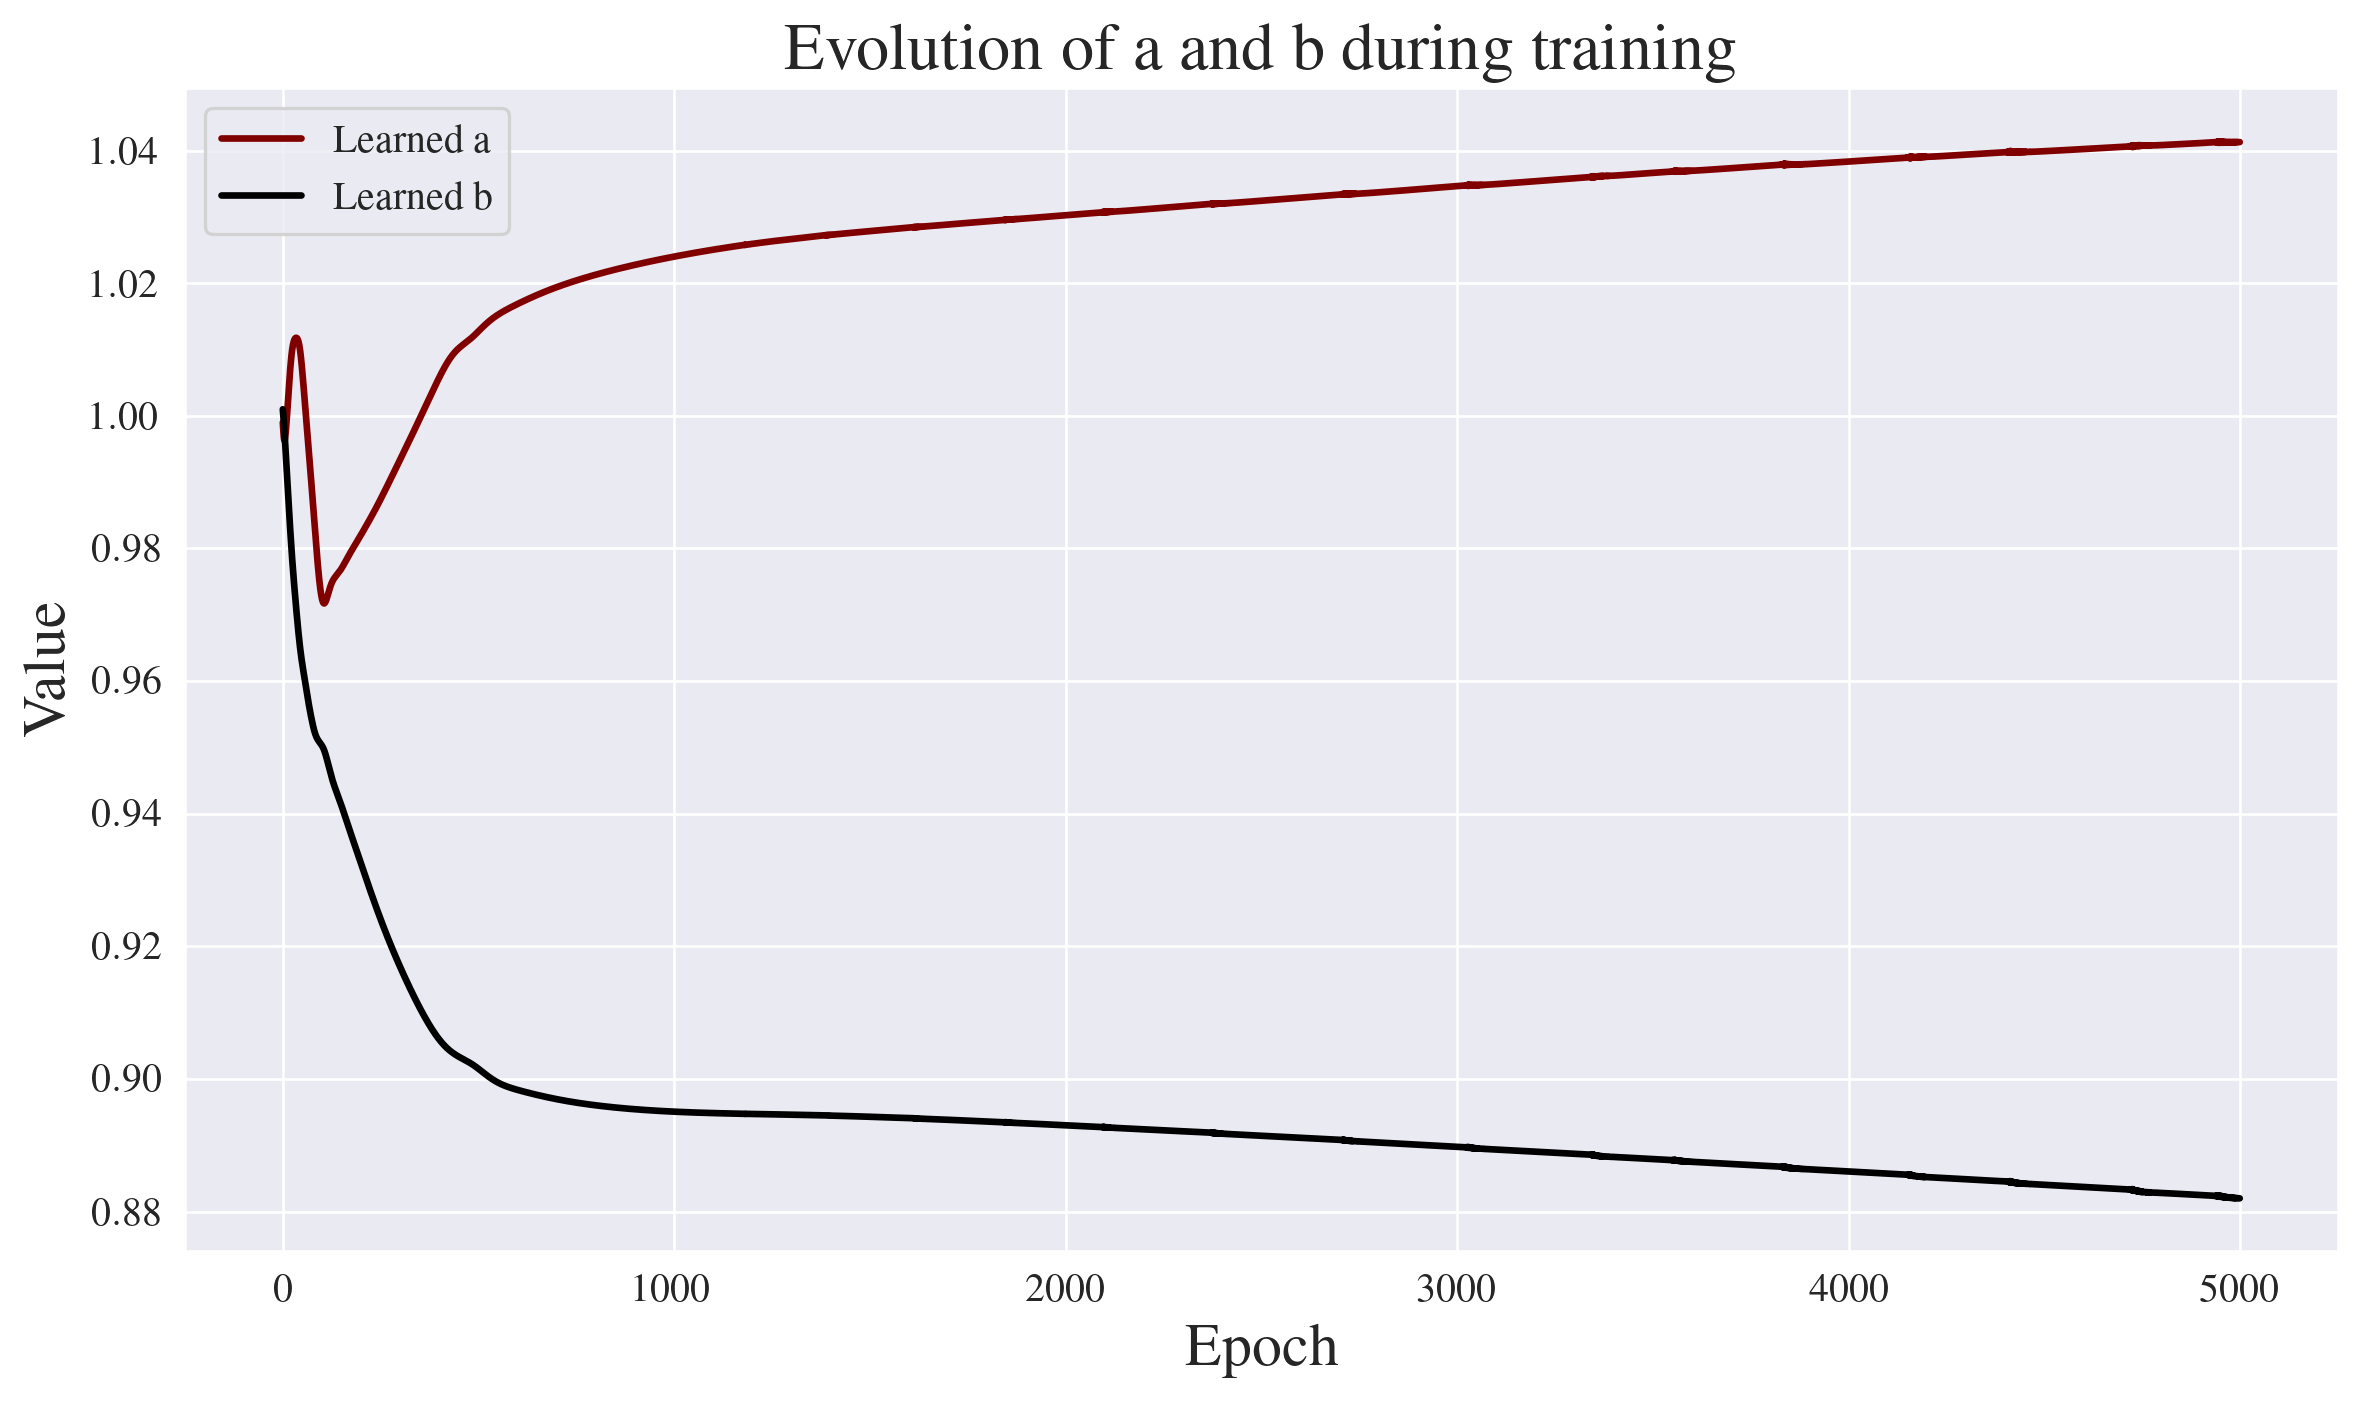

In [2]:
# 1) Set up the true solution and RHS for reference
def u_exact(x_, y_):
    return np.exp(-x_)*(x_ + y_**3)


def f_rhs(x_, y_, a_, b_):
    return np.exp(-x_)*(x_ - a_ + y_**3 + b_*y_)


# 2) Generate collocation points
N_b = 200  # boundary points
N_f = 5000  # interior collocation (physics) points
N_a = 10  # very few interior “analytic” points

# boundary: x=0, x=1, y=0, y=1
xb0 = np.zeros((N_b, 1))
yb0 = np.random.rand(N_b, 1)
xb1 = np.ones((N_b, 1))
yb1 = np.random.rand(N_b, 1)
yb2 = np.zeros((N_b, 1))
xb2 = np.random.rand(N_b, 1)
yb3 = np.ones((N_b, 1))
xb3 = np.random.rand(N_b, 1)

X_b = np.vstack([
    np.hstack([xb0, yb0]),
    np.hstack([xb1, yb1]),
    np.hstack([xb2, yb2]),
    np.hstack([xb3, yb3]),
])
u_b = np.vstack([
    yb0**3,
    (1 + yb1**3)/np.e,
    xb2*np.exp(-xb2),
    np.exp(-xb3)*(1 + xb3),
])

# interior physics points
X_f = np.random.rand(N_f, 2)

# a few interior analytic points
X_a = np.random.rand(N_a, 2)
u_a = u_exact(X_a[:, 0:1], X_a[:, 1:2])

# 3) Build the neural net model u_nn(x,y)
inp = Input(shape=(2,), name="xy")
x = Dense(50, activation="tanh")(inp)
x = Dense(50, activation="tanh")(x)
x = Dense(50, activation="tanh")(x)
out = Dense(1, activation=None)(x)
model = Model(inputs=inp, outputs=out)

# 4) Trainable parameters a, b
a = tf.Variable(1.0, dtype=tf.float32, trainable=True, name="a")
b = tf.Variable(1.0, dtype=tf.float32, trainable=True, name="b")

# 5) Optimizer
optimizer = Adam(learning_rate=1e-3)


# 6) One training step
@tf.function
def train_step(X_b_, u_b_, X_f_, X_a_, u_a_):
    with tf.GradientTape(persistent=True) as tape:
        # boundary loss
        u_pred_b = model(X_b_, training=True)
        loss_b = tf.reduce_mean((u_pred_b - u_b_)**2)

        # physics loss: ∇² u - f = 0
        with tf.GradientTape(persistent=True) as g2:
            g2.watch(X_f_)
            with tf.GradientTape(persistent=True) as g:
                g.watch(X_f_)
                u_f = model(X_f_, training=True)
            du = g.gradient(u_f, X_f_)
            u_x = du[:, 0:1]
            u_y = du[:, 1:2]
        d2u = g2.gradient(du, X_f_)
        u_xx = d2u[:, 0:1]
        u_yy = d2u[:, 1:2]
        lap = u_xx + u_yy
        x_f = X_f_[:, 0:1]
        y_f = X_f_[:, 1:2]
        f_val = tf.exp(-x_f)*(x_f - a + y_f**3 + b*y_f)
        loss_phys = tf.reduce_mean((lap - f_val)**2)

        # analytic‐point loss (very few points)
        u_pred_a = model(X_a_, training=True)
        loss_a = tf.reduce_mean((u_pred_a - u_a_)**2)

        loss_ = loss_b + loss_phys + 1e-3*loss_a

    # compute gradients and apply
    grads = tape.gradient(loss_, model.trainable_variables + [a, b])
    optimizer.apply_gradients(zip(grads, model.trainable_variables + [a, b]))
    return loss_, loss_b, loss_phys, loss_a


# 7) Training loop
epochs = 5000
history = {"a": [], "b": [], "loss": []}

for epoch in range(1, epochs + 1):
    loss, lb, lp, la = train_step(
        tf.convert_to_tensor(X_b, tf.float32),
        tf.convert_to_tensor(u_b, tf.float32),
        tf.convert_to_tensor(X_f, tf.float32),
        tf.convert_to_tensor(X_a, tf.float32),
        tf.convert_to_tensor(u_a, tf.float32),
    )
    history["a"].append(a.numpy())
    history["b"].append(b.numpy())
    history["loss"].append(loss.numpy())

    if epoch%500 == 0:
        print(f"Epoch {epoch:5d}: total_loss={loss:.3e}, a={a.numpy():.4f}, b={b.numpy():.4f}")

# 8) Plot the trajectories of a and b
plt.plot(history["a"], label="Learned a")
plt.plot(history["b"], label="Learned b")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.title("Evolution of a and b during training")
plt.show()